In [1]:
!pip install protobuf==4.23.4 --force-reinstall --no-deps -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 8.3 MB/s eta 0:00:00:00:01


In [2]:
import os
import random
import re
import copy
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
import torch.nn as nn

In [3]:
# Reproducibility & device

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


In [4]:
# Dataset loading 
tracks = pd.read_csv(
    "/kaggle/input/fma-free-music-archive-small-medium/fma_metadata/tracks.csv",
    index_col=0,
    header=[0, 1]
)
genres = tracks[('track', 'genre_top')]
subset = tracks[('set', 'subset')]
small_ids = tracks[subset == "small"].index
genres = genres.loc[small_ids].dropna()

genre_list = sorted(genres.unique())
label2id = {g: i for i, g in enumerate(genre_list)}
id2label = {i: g for g, i in label2id.items()}
genres_encoded = genres.map(label2id)

train_ids, test_ids = train_test_split(
    genres.index, test_size=0.2, stratify=genres_encoded, random_state=SEED
)
train_ids, val_ids = train_test_split(
    train_ids, test_size=0.1, stratify=genres_encoded.loc[train_ids], random_state=SEED
)
print(f"Train: {len(train_ids)}  Val: {len(val_ids)}  Test: {len(test_ids)}")

AUDIO_ROOT = "/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small"

Train: 5760  Val: 640  Test: 1600


In [5]:
# dataset class 
class FMASmallDataset(Dataset):
    def __init__(self, ids, labels, feature_extractor, audio_root=AUDIO_ROOT, max_len_seconds=30, train_mode=False):
        self.ids = list(ids)
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.audio_root = audio_root
        self.train_mode = train_mode
        self.max_length = int(16000 * max_len_seconds)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        track_id = int(self.ids[idx])
        label = int(self.labels[track_id])

        folder = f"{track_id // 1000:03d}"
        filename = f"{track_id:06d}.mp3"
        path = os.path.join(self.audio_root, folder, filename)

        try:
            waveform, sr = torchaudio.load(path)
        except Exception:
            waveform = torch.zeros(1, self.max_length)
            sr = 16000

        # Convert to mono
        if waveform.dim() == 2 and waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        waveform = waveform.squeeze()

        # Resample
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)

        # Trim/pad
        if waveform.numel() > self.max_length:
            waveform = waveform[:self.max_length]
        else:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_length - waveform.numel()))

        # feature_extractor expects either List[ndarray] or tensor with shape (samples,)
        inputs = self.feature_extractor(waveform, sampling_rate=16000, return_tensors="pt")
        # inputs["input_values"] shape -> (1, seq_len), return squeezed
        return inputs["input_values"][0], torch.tensor(label, dtype=torch.long)


In [6]:
# Model configs

MODEL_RUNS = [
    #("wav2vec2-base", "facebook/wav2vec2-base-960h"),  
    ("wavlm-base", "microsoft/wavlm-base"),
    #("hubert-base", "facebook/hubert-base-ls960")
]

In [7]:
# Shared training hyperparams

BATCH_SIZE = 4
NUM_WORKERS = 2       
LR_HEAD = 1e-5
LR_FINETUNE = 5e-5
WEIGHT_DECAY = 1e-6

EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 3
LAST_N_LAYERS = 2  

PATIENCE = 2         
MIN_DELTA = 1e-4     


In [8]:
# utility: find classifier param names and layer indices
layer_num_re = re.compile(r"layer\.(\d+)")  # will find 'layer.10' 'layer.11' etc.

def extract_layer_indices(named_parameters):
    """Return sorted unique integer layer indices found in param names."""
    indices = set()
    for name, _ in named_parameters:
        m = layer_num_re.search(name)
        if m:
            try:
                indices.add(int(m.group(1)))
            except:
                pass
    if not indices:
        return []
    return sorted(indices)

def unfreeze_last_n_layers(model, n):
    """Heuristic: unfreeze last n transformer layers based on 'layer.<i>' occurrences.
       Also unfreeze classifier head params.
    """
    # Find layer indices present in model parameter names
    named = list(model.named_parameters())
    indices = extract_layer_indices(named)
    if indices:
        max_idx = max(indices)
        threshold = max_idx - n + 1
    else:
        threshold = None

    # Unfreeze params matching heuristic names
    for name, param in named:
        # always unfreeze classifier / pooler / project heads heuristically
        if any(k in name.lower() for k in ["classifier", "head", "proj", "project", "pooler", "dense", "label"]):
            param.requires_grad = True
            continue
        # unfreeze last transformer layers if we found any layer indices
        if threshold is not None:
            m = layer_num_re.search(name)
            if m:
                idx = int(m.group(1))
                if idx >= threshold:
                    param.requires_grad = True

In [9]:
# training & eval 

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    bar = tqdm(loader, leave=False)
    for x, y in bar:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        logits = outputs.logits
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(correct/total):.3f}")
    avg_loss = total_loss / len(loader.dataset)
    acc = correct / total if total > 0 else 0.0
    return avg_loss, acc

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        bar = tqdm(loader, leave=False)
        for x, y in bar:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            logits = outputs.logits
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(1)
            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(y.cpu().tolist())
            bar.set_postfix(loss=f"{loss.item():.4f}")
    avg_loss = total_loss / len(loader.dataset)
    acc = (np.array(preds_all) == np.array(labels_all)).mean()
    return avg_loss, acc, preds_all, labels_all


RUN: wavlm-base  ->  microsoft/wavlm-base


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-12-08 20:18:58.224372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765225138.406157      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765225138.458929      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of WavLMForSequenceClassification were not initialized from the model checkpoint at microsoft/wavlm-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STAGE 1: Training classifier head only


Epoch 1 Training:   0%|          | 0/1440 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Epoch 1: Train Loss=1.7394, Train Acc=0.3778 | Val Loss=1.5654, Val Acc=0.4469


Epoch 2: Train Loss=1.4297, Train Acc=0.5130 | Val Loss=1.3462, Val Acc=0.5250


Epoch 3: Train Loss=1.2232, Train Acc=0.5948 | Val Loss=1.2729, Val Acc=0.5578


Epoch 4: Train Loss=1.0886, Train Acc=0.6446 | Val Loss=1.3394, Val Acc=0.5453


Epoch 5: Train Loss=0.9785, Train Acc=0.6898 | Val Loss=1.2755, Val Acc=0.5891
Early stopping triggered (Stage 1).

STAGE 2: Fine-tuning last 2 layers + head


Epoch 1: Train Loss=1.2447, Train Acc=0.5797 | Val Loss=1.3966, Val Acc=0.5281


Epoch 2: Train Loss=1.1268, Train Acc=0.6144 | Val Loss=1.3037, Val Acc=0.5391
Early stopping triggered (Stage 2).

Loading best model checkpoint for wavlm-base

Evaluating on TEST set...


TEST Loss: 1.2585  TEST Acc: 0.5625

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.50      0.71      0.59       200
 Experimental       0.47      0.41      0.44       200
         Folk       0.67      0.67      0.67       200
      Hip-Hop       0.76      0.73      0.75       200
 Instrumental       0.52      0.54      0.53       200
International       0.74      0.56      0.64       200
          Pop       0.33      0.35      0.34       200
         Rock       0.57      0.54      0.56       200

     accuracy                           0.56      1600
    macro avg       0.57      0.56      0.56      1600
 weighted avg       0.57      0.56      0.56      1600

Confusion matrix:
 [[143  15   0  18  10   3   9   2]
 [ 33  81   9   5  25   2  26  19]
 [  0   7 133   1  27   5  22   5]
 [ 27   5   2 146   4   8   8   0]
 [ 27  32   1   2 108   3  18   9]
 [ 29   6  18   5   6 111  17   8]
 [ 19  13  20  12  19   9  70  38]
 [  7  12  15

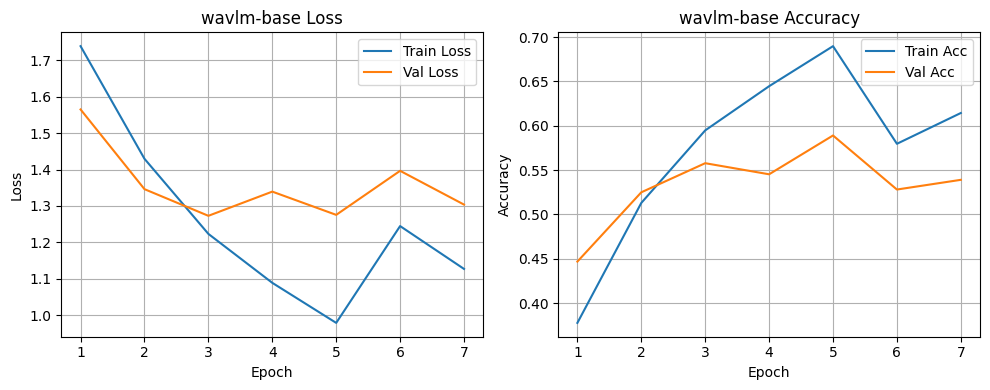

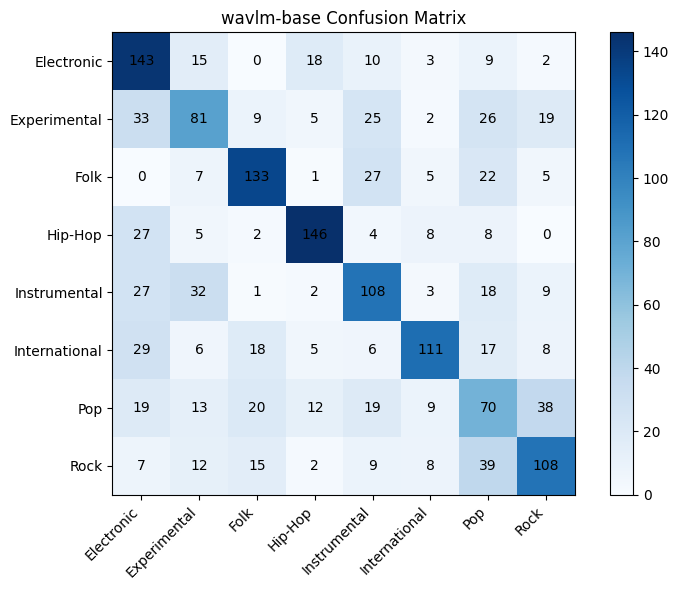

In [10]:
# training loop
results = {}

for run_name, checkpoint in MODEL_RUNS:
    print("\n" + "="*80)
    print("RUN:", run_name, " -> ", checkpoint)
    print("="*80)

    # Load feature extractor & datasets
    feature_extractor = AutoFeatureExtractor.from_pretrained(checkpoint)

    train_ds = FMASmallDataset(train_ids, genres_encoded, feature_extractor, train_mode=True)
    val_ds = FMASmallDataset(val_ids, genres_encoded, feature_extractor)
    test_ds = FMASmallDataset(test_ids, genres_encoded, feature_extractor)

    # Weighted sampler for imbalance
    class_weights = 1. / genres_encoded.value_counts()
    sample_weights = genres_encoded.loc[train_ids].map(class_weights).values
    sampler = WeightedRandomSampler(weights=torch.DoubleTensor(sample_weights), num_samples=len(train_ids), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=(DEVICE=='cuda'))
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=(DEVICE=='cuda'))
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=(DEVICE=='cuda'))

    # Load model
    model = AutoModelForAudioClassification.from_pretrained(
        checkpoint,
        num_labels=len(genre_list),
        ignore_mismatched_sizes=True,
        label2id=label2id,
        id2label=id2label
    ).to(DEVICE)

    # Stage 1: freeze everything except classifier
    for p in model.parameters():
        p.requires_grad = False
    for name, p in model.named_parameters():
        if any(k in name.lower() for k in ["classifier", "head", "proj", "project", "pooler", "dense", "label"]):
            p.requires_grad = True

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(trainable_params, lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    scaler = GradScaler("cuda")  # for mixed precision

    # Scheduler + Early stopping
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, verbose=True)
    best_val_loss = float("inf")
    patience_counter = 0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    print("\nSTAGE 1: Training classifier head only")
    for epoch in range(EPOCHS_STAGE1):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            with autocast("cuda"):  # mixed precision
                outputs = model(x)
                logits = outputs.logits
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        tr_loss = running_loss / total
        tr_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
                x, y = x.to(DEVICE), y.to(DEVICE)
                with autocast("cuda"):
                    outputs = model(x)
                    logits = outputs.logits
                    loss = criterion(logits, y)
                val_loss += loss.item() * x.size(0)
                pred = logits.argmax(dim=1)
                val_correct += (pred == y).sum().item()
                val_total += y.size(0)
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}: Train Loss={tr_loss:.4f}, Train Acc={tr_acc:.4f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        if val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{run_name}.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered (Stage 1).")
                break

    # Stage 2: unfreeze last N layers + head
    print("\nSTAGE 2: Fine-tuning last", LAST_N_LAYERS, "layers + head")
    for p in model.parameters():
        p.requires_grad = False
    for name, p in model.named_parameters():
        if any(k in name.lower() for k in ["classifier", "head", "proj", "project", "pooler", "dense", "label"]):
            p.requires_grad = True
    unfreeze_last_n_layers(model, LAST_N_LAYERS)

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(trainable_params, lr=LR_FINETUNE, weight_decay=WEIGHT_DECAY)
    scaler = GradScaler("cuda")
    patience_counter = 0

    for epoch in range(EPOCHS_STAGE2):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            with autocast("cuda"):
                outputs = model(x)
                logits = outputs.logits
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * x.size(0)
            correct += (logits.argmax(dim=1) == y).sum().item()
            total += y.size(0)

        tr_loss = running_loss / total
        tr_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
                x, y = x.to(DEVICE), y.to(DEVICE)
                with autocast("cuda"):
                    outputs = model(x)
                    logits = outputs.logits
                    loss = criterion(logits, y)
                val_loss += loss.item() * x.size(0)
                pred = logits.argmax(dim=1)
                val_correct += (pred == y).sum().item()
                val_total += y.size(0)
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        val_loss /= val_total
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}: Train Loss={tr_loss:.4f}, Train Acc={tr_acc:.4f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        if val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{run_name}.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered (Stage 2).")
                break

    # Load best model & evaluate on test set
    print("\nLoading best model checkpoint for", run_name)
    model.load_state_dict(torch.load(f"best_{run_name}.pt"))

    print("\nEvaluating on TEST set...")
    test_loss, test_acc, preds, labels_true = eval_epoch(model, test_loader, criterion)
    print(f"TEST Loss: {test_loss:.4f}  TEST Acc: {test_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(labels_true, preds, target_names=genre_list))

    cm = confusion_matrix(labels_true, preds)
    print("Confusion matrix:\n", cm)

    # Plot loss & accuracy curves
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{run_name} Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_accs, label="Train Acc")
    plt.plot(epochs_range, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{run_name} Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Confusion matrix plot
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(f"{run_name} Confusion Matrix")
    plt.colorbar()
    plt.xticks(range(len(genre_list)), genre_list, rotation=45, ha="right")
    plt.yticks(range(len(genre_list)), genre_list)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

    # Save results summary
    results[run_name] = {
        "model_checkpoint": checkpoint,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "classification_report": classification_report(labels_true, preds, target_names=genre_list, output_dict=True),
        "confusion_matrix": cm
    }

In [11]:
# Final aggregated summary 
print("\nAll runs finished. Summary:")
for r, v in results.items():
    print(f"\n--- {r} ---")
    print("Checkpoint:", v["model_checkpoint"])
    print(f"Test Acc: {v['test_acc']:.4f}  Test Loss: {v['test_loss']:.4f}")


All runs finished. Summary:

--- wavlm-base ---
Checkpoint: microsoft/wavlm-base
Test Acc: 0.5625  Test Loss: 1.2585
